In [1]:
import pandas as pd # type: ignore
import numpy as np # type: ignore

In [2]:
# Import the FoodDemandForecaster class
from forecaster import FoodDemandForecaster

# Create an instance of the forecaster
forecaster = FoodDemandForecaster()

# Load the data (this will automatically call preprocess_data() which includes region mapping and meal filtering)
forecaster.load_data()

# If you want to view the regional mapping after it's been created
print("\nRegional Mapping:")
for center_id, region in forecaster.regional_mapping.items():
    print(f"Center ID {center_id} -> {region}")

# Check the dataset before and after filtering
# The original dataset should be in forecaster.train_data
print("\nData shape after filtering:")
print(f"Train data shape: {forecaster.train_data.shape}")
print(f"Unique meal IDs remaining: {len(forecaster.train_data['meal_id'].unique())}")

# You can also access the filtered meal IDs that were removed
removed_meals = [1571, 2104, 2956, 2490, 2569, 2664]
print(f"\nMeals filtered out: {removed_meals}")

# To see data availability analysis results
print("\nData Availability Analysis:")
for key, info in list(forecaster.data_availability.items())[:5]:  # Show first 5 items
    print(f"{key}: {info['records']} records, {info['weeks']} weeks, Sufficient: {info['sufficient']}")

c:\python_projects\prophet-demand-forecast\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


🍽️ Loaded 45 meals from existing meal_database.json
📊 Processed meal data with perishable percentages and portion weights
   • 1885: Basic Vegetable Pasta Bake
     └ 40.0% perishable, 0.40kg/portion, Vegetarian
   • 1993: Simple Spinach and Chickpea Curry
     └ 45.0% perishable, 0.51kg/portion, Vegetarian
   • 2539: Basic Tofu Stir Fry
     └ 80.0% perishable, 0.55kg/portion, Vegetarian
   • ... and 42 more
✅ Loaded train.csv: 456548 records
📋 Train columns: ['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders']
ℹ️ test.csv not found - continuing without it (not required for forecasting)
🍽️ Filtering meals with insufficient coverage...
📊 Initial meals: 51 total
📊 Initial records: 456,548
🗑️ Removing meals: [1571, 2104, 2956, 2490, 2569, 2664]
✅ Filtering complete:
   • Meals removed: 6
   • Records removed: 38,746
   • Remaining meals: 45
   • Remaining records: 417,802
   • Data reduction: 8.5%
📍 Loading reg

KeyError: 'records'

In [3]:
# remove Lyon
forecaster.train_data = forecaster.train_data.loc[forecaster.train_data['region'] != "Region-Lyon"]

In [4]:
forecaster.train_data.drop(columns=['emailer_for_promotion', 'homepage_featured', 'base_price'], inplace=True)

In [5]:
print("Data Points in Total by region:")
forecaster.train_data['region'].value_counts()

Data Points in Total by region:


region
Region-Kassel    197575
Region-Luzern    105864
Region-Wien       86302
Name: count, dtype: int64

In [6]:
# Average per Region
regions = ['Region-Kassel', "Region-Luzern", "Region-Wien"]
for region in regions:
    len(forecaster.train_data[forecaster.train_data['region'] == region]) / 145
    print(f"Average data points per week in {region}: {len(forecaster.train_data[forecaster.train_data['region'] == region]) / 145:.2f}")

Average data points per week in Region-Kassel: 1362.59
Average data points per week in Region-Luzern: 730.10
Average data points per week in Region-Wien: 595.19


In [7]:
for region in regions:
    print(f"Average number of meals per week in {region}: {forecaster.train_data['num_orders'][forecaster.train_data['region'] == region].sum() / 145:.2f}")

Average number of meals per week in Region-Kassel: 417784.00
Average number of meals per week in Region-Luzern: 146010.45
Average number of meals per week in Region-Wien: 124915.57


In [8]:
for region in regions:
    region_data = forecaster.train_data[forecaster.train_data['region'] == region]
    # Calculate revenue per record
    region_data['revenue'] = region_data['num_orders'] * region_data['checkout_price']
    
    # Calculate total meals sold for this region
    total_meals_sold = region_data['num_orders'].sum()
    
    # Group by week and calculate various metrics
    weekly_stats = region_data.groupby('week').agg({
        'revenue': 'sum',
        'num_orders': 'sum'  # Sum the number of orders per week
    }).reset_index()
    
    # Calculate statistics
    total_weeks = weekly_stats['week'].nunique()
    total_revenue = weekly_stats['revenue'].sum()
    mean_revenue = weekly_stats['revenue'].mean()
    mean_meals_per_week = weekly_stats['num_orders'].mean()
    
    # Format numbers with thousands separator (European style)
    total_revenue_formatted = f"{total_revenue:,.2f}"
    mean_revenue_formatted = f"{mean_revenue:,.2f}"
    total_meals_formatted = f"{total_meals_sold:,}"
    mean_meals_formatted = f"{mean_meals_per_week:,.2f}"
    
    print(f"Region: {region}")
    print(f"  - Total weeks with data: {total_weeks}")
    print(f"  - Total revenue: {total_revenue_formatted} EUR")
    print(f"  - Average revenue per week: {mean_revenue_formatted} EUR")
    print(f"  - Total meals sold: {total_meals_formatted}")
    print(f"  - Average meals sold per week: {mean_meals_formatted}")

Region: Region-Kassel
  - Total weeks with data: 145
  - Total revenue: 15,631,792,005.79 EUR
  - Average revenue per week: 107,805,462.11 EUR
  - Total meals sold: 60,578,680
  - Average meals sold per week: 417,784.00
Region: Region-Luzern
  - Total weeks with data: 145
  - Total revenue: 5,788,937,305.94 EUR
  - Average revenue per week: 39,923,705.56 EUR
  - Total meals sold: 21,171,515
  - Average meals sold per week: 146,010.45
Region: Region-Wien
  - Total weeks with data: 145
  - Total revenue: 4,847,332,717.01 EUR
  - Average revenue per week: 33,429,880.81 EUR
  - Total meals sold: 18,112,757
  - Average meals sold per week: 124,915.57


In [9]:
forecaster.train_data

,id,week,center_id,meal_id,checkout_price,num_orders,region
0,1379560,1,55,1885,136.83,177,Region-Kassel
1,1466964,1,55,1993,136.83,270,Region-Kassel
2,1346989,1,55,2539,134.86,189,Region-Kassel
3,1338232,1,55,2139,339.50,54,Region-Kassel
4,1448490,1,55,2631,243.50,40,Region-Kassel
...,...,...,...,...,...,...,...
456540,1035758,145,61,1525,319.13,134,Region-Wien
456541,1010438,145,61,2704,321.13,67,Region-Wien
456542,1116711,145,61,2492,455.93,42,Region-Wien
456543,1271326,145,61,1543,484.09,68,Region-Wien


In [10]:
import pandas as pd
import json

# Load the meal database from JSON file
with open('meal_database.json', 'r') as file:
    meal_data = json.load(file)

# Create a list to store the meal information
meals_list = []

# Extract data from the JSON structure
for meal_id, details in meal_data.items():
    # Calculate average ingredient weight
    avg_ingredient_weight = sum(details['kg_per_10_persons']) / len(details['kg_per_10_persons'])
    
    # Calculate perishability ratio (percentage of perishable ingredients)
    perishability = sum(details['perishable']) / len(details['perishable']) * 100
    
    # Create a dictionary for this meal
    meal_info = {
        'meal_id': int(meal_id),
        'name': details['name'],
    }
    
    meals_list.append(meal_info)

# Create DataFrame
meals_df = pd.DataFrame(meals_list)

# Sort by meal_id for better readability
meals_df = meals_df.sort_values('meal_id').reset_index(drop=True)

# Display the DataFrame
print(f"Loaded {len(meals_df)} meals from the database")
meals_df.head(20)

Loaded 45 meals from the database


,meal_id,name
0,1062,Beef Goulash
1,1109,Wild Mushroom Risotto
2,1198,Vegetable Stir Fry
3,1207,Authentic Carbonara
4,1216,Gourmet Curry Selection
5,1230,Teriyaki Salmon Bowl
6,1247,Gourmet Chicken Alfredo
7,1248,Simple Swedish Meatballs
8,1311,Fish Tacos
9,1438,Beef Burgers


In [11]:
import json

# Load the meal database from JSON file
with open('meal_database.json', 'r') as file:
    meal_data = json.load(file)

# Create a list to store the ingredients information
ingredients_list = []

# Extract ingredient data from each meal
for meal_id, details in meal_data.items():
    for i, ingredient in enumerate(details['ingredients']):
        # Get the corresponding data for this ingredient
        kg_per_10 = details['kg_per_10_persons'][i]
        price_pct = details['price_distribution'][i]
        is_perishable = details['perishable'][i]
        storage_m3 = details['storage_m3'][i]  # Adding the storage volume data
        
        # Create a record for this ingredient
        ingredient_info = {
            'meal_id': int(meal_id),
            'meal_name': details['name'],
            'ingredient': ingredient,
            'kg_per_10_persons': kg_per_10,
            'price_percentage': price_pct,
            'is_perishable': is_perishable,
            'storage_m3': storage_m3  # Including storage volume in the dictionary
        }
        
        ingredients_list.append(ingredient_info)

# Create DataFrame
ingredients_df = pd.DataFrame(ingredients_list)

# Display information about the DataFrame
print(f"Created ingredients DataFrame with {len(ingredients_df)} records")
print(f"Number of unique ingredients: {ingredients_df['ingredient'].nunique()}")
print(f"Number of meals: {ingredients_df['meal_id'].nunique()}")

# Show the first few rows with the new storage_m3 column
ingredients_df.head()

Created ingredients DataFrame with 225 records
Number of unique ingredients: 202
Number of meals: 45


,meal_id,meal_name,ingredient,kg_per_10_persons,price_percentage,is_perishable,storage_m3
0,1885,Basic Vegetable Pasta Bake,Pasta,2.00,30,False,0.0050
1,1885,Basic Vegetable Pasta Bake,Fresh mixed vegetables,1.50,40,True,0.0080
2,1885,Basic Vegetable Pasta Bake,Powdered cheese sauce mix,0.20,20,False,0.0005
3,1885,Basic Vegetable Pasta Bake,Dried herb blend,0.05,5,False,0.0001
4,1885,Basic Vegetable Pasta Bake,Breadcrumb topping,0.20,5,False,0.0006


In [12]:
ingredients_df.loc[ingredients_df['meal_id'] == 1778]

,meal_id,meal_name,ingredient,kg_per_10_persons,price_percentage,is_perishable,storage_m3
35,1778,Chicken Curry,Chicken pieces,2.00,55,True,0.0040
36,1778,Chicken Curry,Curry sauce,1.00,15,True,0.0015
37,1778,Chicken Curry,Basmati rice,2.00,15,False,0.0040
38,1778,Chicken Curry,Naan bread,0.70,12,True,0.0025
39,1778,Chicken Curry,Fresh herbs,0.05,3,True,0.0003


In [13]:
import pandas as pd
import json

# Load the meal database from JSON file
with open('meal_database.json', 'r') as file:
    meal_data = json.load(file)

# Create a list to store the meal information
meals_list = []

# Extract data from the JSON structure
for meal_id, details in meal_data.items():
    # Skip entries without complete data
    if 'name' not in details or 'perishable' not in details:
        continue
        
    # Calculate average ingredient weight
    avg_ingredient_weight = sum(details['kg_per_10_persons']) / len(details['kg_per_10_persons'])
    
    # Calculate perishability ratio (percentage of perishable ingredients)
    perishability = sum(details['perishable']) / len(details['perishable']) * 100
    
    # Create a dictionary for this meal
    meal_info = {
        'meal_id': int(meal_id),
        'name': details['name'],
    }
    
    meals_list.append(meal_info)

# Create DataFrame
meals_df = pd.DataFrame(meals_list)

# Sort by meal_id for better readability
meals_df = meals_df.sort_values('meal_id').reset_index(drop=True)

# Now calculate storage requirements based on ingredients
# Initialize storage columns with zeros
meals_df['storage_cool'] = 0.0
meals_df['storage_warehouse'] = 0.0

# For each meal, aggregate storage requirements from ingredients
for meal_id in meals_df['meal_id']:
    # Get all ingredients for this meal
    meal_ingredients = ingredients_df[ingredients_df['meal_id'] == meal_id]
    
    # Sum storage for perishable ingredients (cool storage)
    cool_storage = meal_ingredients[meal_ingredients['is_perishable']]['storage_m3'].sum()
    
    # Sum storage for non-perishable ingredients (warehouse storage)
    warehouse_storage = meal_ingredients[~meal_ingredients['is_perishable']]['storage_m3'].sum()
    
    # Update the meals dataframe
    meals_df.loc[meals_df['meal_id'] == meal_id, 'storage_cool'] = cool_storage
    meals_df.loc[meals_df['meal_id'] == meal_id, 'storage_warehouse'] = warehouse_storage

# Display the DataFrame
print(f"Loaded {len(meals_df)} meals from the database")
# Format storage columns to 4 decimal places for better readability
meals_df['storage_cool'] = meals_df['storage_cool'].round(4)
meals_df['storage_warehouse'] = meals_df['storage_warehouse'].round(4)
meals_df.head(20)

Loaded 45 meals from the database


,meal_id,name,storage_cool,storage_warehouse
0,1062,Beef Goulash,0.0152,0.0000
1,1109,Wild Mushroom Risotto,0.0071,0.0041
2,1198,Vegetable Stir Fry,0.0126,0.0031
3,1207,Authentic Carbonara,0.0083,0.0000
4,1216,Gourmet Curry Selection,0.0155,0.0044
5,1230,Teriyaki Salmon Bowl,0.0097,0.0041
6,1247,Gourmet Chicken Alfredo,0.0170,0.0000
7,1248,Simple Swedish Meatballs,0.0120,0.0009
8,1311,Fish Tacos,0.0103,0.0025
9,1438,Beef Burgers,0.0140,0.0000


In [14]:
for region in regions:
    region_data = forecaster.train_data[forecaster.train_data['region'] == region]
    # Calculate revenue per record
    region_data['revenue'] = region_data['num_orders'] * region_data['checkout_price']
    
    # Add storage requirements data to each order
    region_data = region_data.merge(meals_df[['meal_id', 'storage_cool', 'storage_warehouse']], 
                                   on='meal_id', how='left')
    
    # Calculate storage requirements per order
    region_data['total_cool_storage'] = region_data['num_orders'] * region_data['storage_cool']
    region_data['total_warehouse_storage'] = region_data['num_orders'] * region_data['storage_warehouse']
    
    # Group by week and sum metrics
    weekly_stats = region_data.groupby('week').agg({
        'revenue': 'sum',
        'total_cool_storage': 'sum',
        'total_warehouse_storage': 'sum'
    }).reset_index()
    
    # Calculate statistics
    total_weeks = weekly_stats['week'].nunique()
    total_revenue = weekly_stats['revenue'].sum()
    mean_revenue = weekly_stats['revenue'].mean()
    mean_cool_storage = weekly_stats['total_cool_storage'].mean()
    mean_warehouse_storage = weekly_stats['total_warehouse_storage'].mean()
    
    # Format numbers with thousands separator (European style)
    total_revenue_formatted = f"{total_revenue:,.2f}"
    mean_revenue_formatted = f"{mean_revenue:,.2f}"
    mean_cool_storage_formatted = f"{mean_cool_storage:.4f}"
    mean_warehouse_storage_formatted = f"{mean_warehouse_storage:.4f}"
    
    print(f"Region: {region}")
    print(f"  - Total weeks with data: {total_weeks}")
    print(f"  - Total revenue: {total_revenue_formatted} EUR")
    print(f"  - Average revenue per week: {mean_revenue_formatted} EUR")
    print(f"  - Average cool storage required per week: {mean_cool_storage_formatted} m³")
    print(f"  - Give that 20% more for safety, average cool storage required per week: {(mean_cool_storage * 1.2).__round__():,.2f} m³")
    print(f"  - Average warehouse storage required per week: {mean_warehouse_storage_formatted} m³")
    print(f"  - Give that 20% more for safety, average warehouse storage required per week: {(mean_warehouse_storage * 1.2).__round__():,.2f} m³")

Region: Region-Kassel
  - Total weeks with data: 145
  - Total revenue: 15,631,792,005.79 EUR
  - Average revenue per week: 107,805,462.11 EUR
  - Average cool storage required per week: 4938.1327 m³
  - Give that 20% more for safety, average cool storage required per week: 5,926.00 m³
  - Average warehouse storage required per week: 1060.3551 m³
  - Give that 20% more for safety, average warehouse storage required per week: 1,272.00 m³
Region: Region-Luzern
  - Total weeks with data: 145
  - Total revenue: 5,788,937,305.94 EUR
  - Average revenue per week: 39,923,705.56 EUR
  - Average cool storage required per week: 1797.3626 m³
  - Give that 20% more for safety, average cool storage required per week: 2,157.00 m³
  - Average warehouse storage required per week: 305.1328 m³
  - Give that 20% more for safety, average warehouse storage required per week: 366.00 m³
Region: Region-Wien
  - Total weeks with data: 145
  - Total revenue: 4,847,332,717.01 EUR
  - Average revenue per week: 33

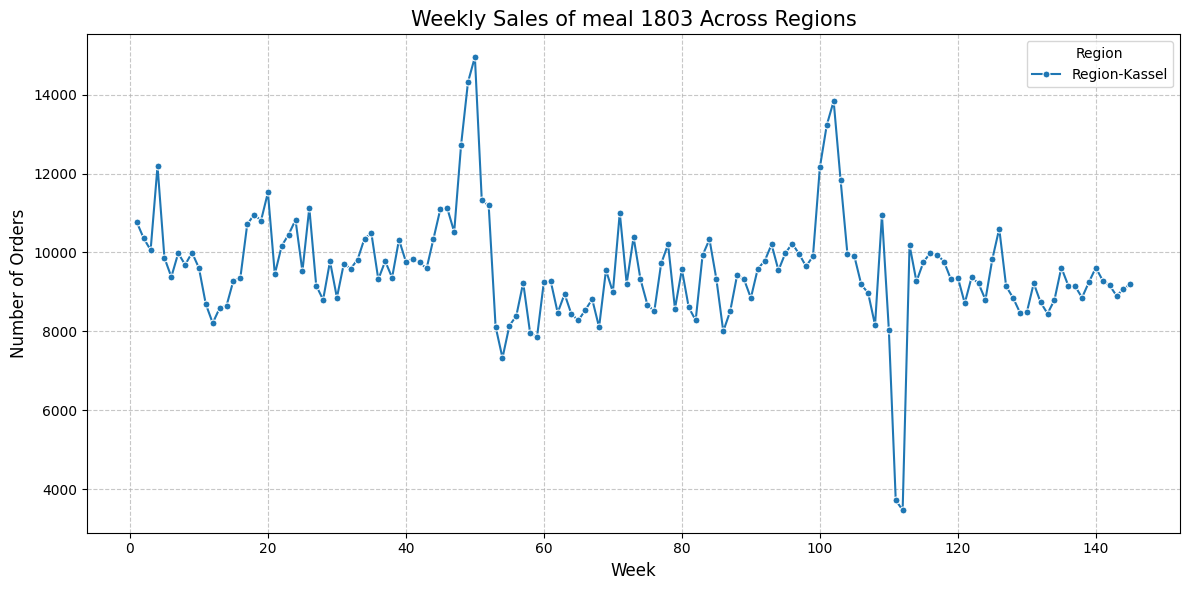

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the meal_id for Chicken Curry
#this_id = meals_df[meals_df['name'] == 'Chicken Curry']['meal_id'].iloc[0]
this_id = 1803
# Create a figure with appropriate size
plt.figure(figsize=(12, 6))

# Create empty DataFrames to store weekly sales data for each region
weekly_sales = []

# Loop through each region and get the weekly data for Chicken Curry
for region in regions:
    # Filter data for this region and for Chicken Curry
    region_meal_data = forecaster.train_data[
        (forecaster.train_data['region'] == region) & 
        (forecaster.train_data['meal_id'] == this_id)
    ]
    
    # Group by week and sum the number of orders
    weekly_data = region_meal_data.groupby('week')['num_orders'].sum().reset_index()
    weekly_data['region'] = region
    
    # Append to our list
    weekly_sales.append(weekly_data)

# Combine all regions' data
all_regions_data = pd.concat(weekly_sales)

# Create the plot
sns.lineplot(data=all_regions_data, x='week', y='num_orders', hue='region', marker='o', markersize=5)

# Add labels and title
plt.title(f'Weekly Sales of meal {this_id} Across Regions', fontsize=15)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Improve legend
plt.legend(title='Region', fontsize=10)


# Adjust layout and show plot
plt.tight_layout()
plt.show()

### XYZ-Analyse

In [25]:
def berechne_variationskoeffizient(zeitreihe):
    # Standardabweichung berechnen
    std = np.std(zeitreihe, ddof=1)  # ddof=1 für Stichprobe
    
    # Mittelwert berechnen
    mittelwert = np.mean(zeitreihe)
    #print(f"Standardabweichung: {std}, Mittelwert: {mittelwert}")
    # Variationskoeffizient berechnen
    v = (std / mittelwert) * 100 if mittelwert != 0 else float('inf')
    
    return v

def xyz_klassifizierung(variationskoeffizient):
    if variationskoeffizient <= 10:
        return 'X'
    elif variationskoeffizient <= 25:
        return 'Y'
    else:
        return 'Z'

In [35]:
# Create an empty list to collect the analysis results
xyz_results = []

unique_meal_ids = forecaster.train_data['meal_id'].unique()

for meal_id in unique_meal_ids:
    meal_name = meals_df['name'][meals_df['meal_id'] == meal_id].values[0]
    
    for region in regions:
        # Daten für das Gericht in dieser Region extrahieren
        region_data = forecaster.train_data[
            (forecaster.train_data['region'] == region) & 
            (forecaster.train_data['meal_id'] == meal_id)
        ]
        
        # Für bessere Analyse nach Wochen gruppieren
        weekly_data = region_data.groupby('week')['num_orders'].sum().reset_index()
        
        # Variationskoeffizient berechnen
        v = berechne_variationskoeffizient(weekly_data['num_orders'])
        
        # XYZ-Kategorie bestimmen
        kategorie = xyz_klassifizierung(v)
        
        # Durchschnitt pro Woche
        durchschnitt = weekly_data['num_orders'].mean()
        
        # Ergebnisse zum List hinzufügen
        xyz_results.append({
            'meal_id': meal_id,
            'meal_name': meal_name,
            'region': region,
            'variationskoeffizient': round(v, 2),
            'xyz_kategorie': kategorie,
            'durchschnitt_pro_woche': round(durchschnitt, 2)
        })

# Convert results list to DataFrame
xyz_df = pd.DataFrame(xyz_results)

# Display the DataFrame
print("XYZ-Analyse als DataFrame:")
xyz_df.head()

# Zusammenfassung wie viele X,Y und Z pro Region
xyz_summary = xyz_df.groupby(['region', 'xyz_kategorie']).size().unstack(fill_value=0)
# Display the summary DataFrame
print("\nXYZ-Kategorisierung Zusammenfassung:")
print(xyz_summary)

XYZ-Analyse als DataFrame:

XYZ-Kategorisierung Zusammenfassung:
xyz_kategorie  Y   Z
region              
Region-Kassel  6  39
Region-Luzern  3  42
Region-Wien    2  43


In [33]:
def abc_klassifizierung(wert_prozent):
    """
    Klassifiziert einen Artikel basierend auf seinem prozentualen Anteil am Gesamtwert
    A: Wichtige Artikel (ca. 80% des Wertes)
    B: Mittelwichtige Artikel (ca. 15% des Wertes) 
    C: Weniger wichtige Artikel (ca. 5% des Wertes)
    """
    if wert_prozent <= 80:
        return 'A'
    elif wert_prozent <= 95:
        return 'B'
    else:
        return 'C'

# ABC-Analyse basierend auf Umsatz pro Gericht, getrennt nach Regionen
abc_results = []

# Für jede Region separat analysieren
for region in regions:
    # Daten für diese Region filtern
    region_data = forecaster.train_data[forecaster.train_data['region'] == region]
    
    # Gesamtumsatz für diese Region berechnen
    region_data['revenue'] = region_data['num_orders'] * region_data['checkout_price']
    total_region_revenue = region_data['revenue'].sum()
    
    # Umsatz pro Gericht in dieser Region berechnen
    meal_revenue = {}
    for meal_id in unique_meal_ids:
        meal_data = region_data[region_data['meal_id'] == meal_id]
        revenue = meal_data['revenue'].sum()
        meal_revenue[meal_id] = revenue
    
    # Nach Umsatz sortieren (absteigend)
    sorted_meals = sorted(meal_revenue.items(), key=lambda x: x[1], reverse=True)
    
    # Kumulativen Anteil berechnen und ABC-Klassen zuweisen
    cum_percent = 0
    for meal_id, revenue in sorted_meals:
        if meal_id in meals_df['meal_id'].values:  # Sicherheitsprüfung
            meal_name = meals_df['name'][meals_df['meal_id'] == meal_id].values[0]
            
            # Prozentualer Anteil am Gesamtumsatz der Region
            percent = (revenue / total_region_revenue) * 100 if total_region_revenue > 0 else 0
            cum_percent += percent
            
            # ABC-Kategorie bestimmen
            kategorie = abc_klassifizierung(cum_percent)
            
            # Ergebnis sammeln
            abc_results.append({
                'meal_id': meal_id,
                'meal_name': meal_name,
                'region': region,
                'revenue': round(revenue, 2),
                'percent': round(percent, 2),
                'cumulative_percent': round(cum_percent, 2),
                'abc_kategorie': kategorie
            })

# DataFrame erstellen
abc_df = pd.DataFrame(abc_results)

# Regionsweise anzeigen
print("ABC-Analyse nach Regionen:")
for region in regions:
    print(f"\nRegion: {region}")
    region_abc = abc_df[abc_df['region'] == region].sort_values('cumulative_percent')
    print(region_abc.head(10))  # Zeige die Top 10 Gerichte pro Region

# Zusammenfassen nach Kategorie und Region
category_summary = abc_df.groupby(['region', 'abc_kategorie']).size().reset_index(name='count')
print("\nZusammenfassung der ABC-Kategorien nach Region:")
category_summary

ABC-Analyse nach Regionen:

Region: Region-Kassel
   meal_id                   meal_name         region       revenue  percent  \
0     2290             Beef Stroganoff  Region-Kassel  1.205285e+09     7.71   
1     1727             Scampi Linguine  Region-Kassel  1.022168e+09     6.54   
2     1962        Slow-Braised Chicken  Region-Kassel  9.746554e+08     6.24   
3     1109       Wild Mushroom Risotto  Region-Kassel  9.376142e+08     6.00   
4     2826       Slow-Cooked Beef Ragu  Region-Kassel  8.694278e+08     5.56   
5     1754         BBQ Chicken Platter  Region-Kassel  8.192847e+08     5.24   
6     2707                Seafood Rice  Region-Kassel  8.155398e+08     5.22   
7     1885  Basic Vegetable Pasta Bake  Region-Kassel  7.465903e+08     4.78   
8     1971          Gourmet Grain Bowl  Region-Kassel  6.539187e+08     4.18   
9     2581       Chef's Signature Soup  Region-Kassel  6.177603e+08     3.95   

   cumulative_percent abc_kategorie  
0                7.71          

,region,abc_kategorie,count
0,Region-Kassel,A,20
1,Region-Kassel,B,12
2,Region-Kassel,C,13
3,Region-Luzern,A,18
4,Region-Luzern,B,11
5,Region-Luzern,C,16
6,Region-Wien,A,18
7,Region-Wien,B,11
8,Region-Wien,C,16


In [34]:
for row in abc_df.itertuples():
    print(f"Meal ID: {row.meal_id}, Region: {row.region}, Revenue: {row.revenue} EUR, "
          f"Percent: {row.percent}%, Cumulative Percent: {row.cumulative_percent}%, "
          f"ABC Category: {row.abc_kategorie}")

Meal ID: 2290, Region: Region-Kassel, Revenue: 1205285430.38 EUR, Percent: 7.71%, Cumulative Percent: 7.71%, ABC Category: A
Meal ID: 1727, Region: Region-Kassel, Revenue: 1022168297.95 EUR, Percent: 6.54%, Cumulative Percent: 14.25%, ABC Category: A
Meal ID: 1962, Region: Region-Kassel, Revenue: 974655416.46 EUR, Percent: 6.24%, Cumulative Percent: 20.48%, ABC Category: A
Meal ID: 1109, Region: Region-Kassel, Revenue: 937614189.36 EUR, Percent: 6.0%, Cumulative Percent: 26.48%, ABC Category: A
Meal ID: 2826, Region: Region-Kassel, Revenue: 869427845.86 EUR, Percent: 5.56%, Cumulative Percent: 32.04%, ABC Category: A
Meal ID: 1754, Region: Region-Kassel, Revenue: 819284714.19 EUR, Percent: 5.24%, Cumulative Percent: 37.29%, ABC Category: A
Meal ID: 2707, Region: Region-Kassel, Revenue: 815539779.13 EUR, Percent: 5.22%, Cumulative Percent: 42.5%, ABC Category: A
Meal ID: 1885, Region: Region-Kassel, Revenue: 746590304.28 EUR, Percent: 4.78%, Cumulative Percent: 47.28%, ABC Category: A
M

ABC-XYZ-Kombinationsanalyse:
   meal_id                   meal_name         region abc_kategorie  \
0     2290             Beef Stroganoff  Region-Kassel             A   
1     1727             Scampi Linguine  Region-Kassel             A   
2     1962        Slow-Braised Chicken  Region-Kassel             A   
3     1109       Wild Mushroom Risotto  Region-Kassel             A   
4     2826       Slow-Cooked Beef Ragu  Region-Kassel             A   
5     1754         BBQ Chicken Platter  Region-Kassel             A   
6     2707                Seafood Rice  Region-Kassel             A   
7     1885  Basic Vegetable Pasta Bake  Region-Kassel             A   
8     1971          Gourmet Grain Bowl  Region-Kassel             A   
9     2581       Chef's Signature Soup  Region-Kassel             A   

        revenue  percent xyz_kategorie  variationskoeffizient  \
0  1.205285e+09     7.71             Z                 103.64   
1  1.022168e+09     6.54             Z                  91.

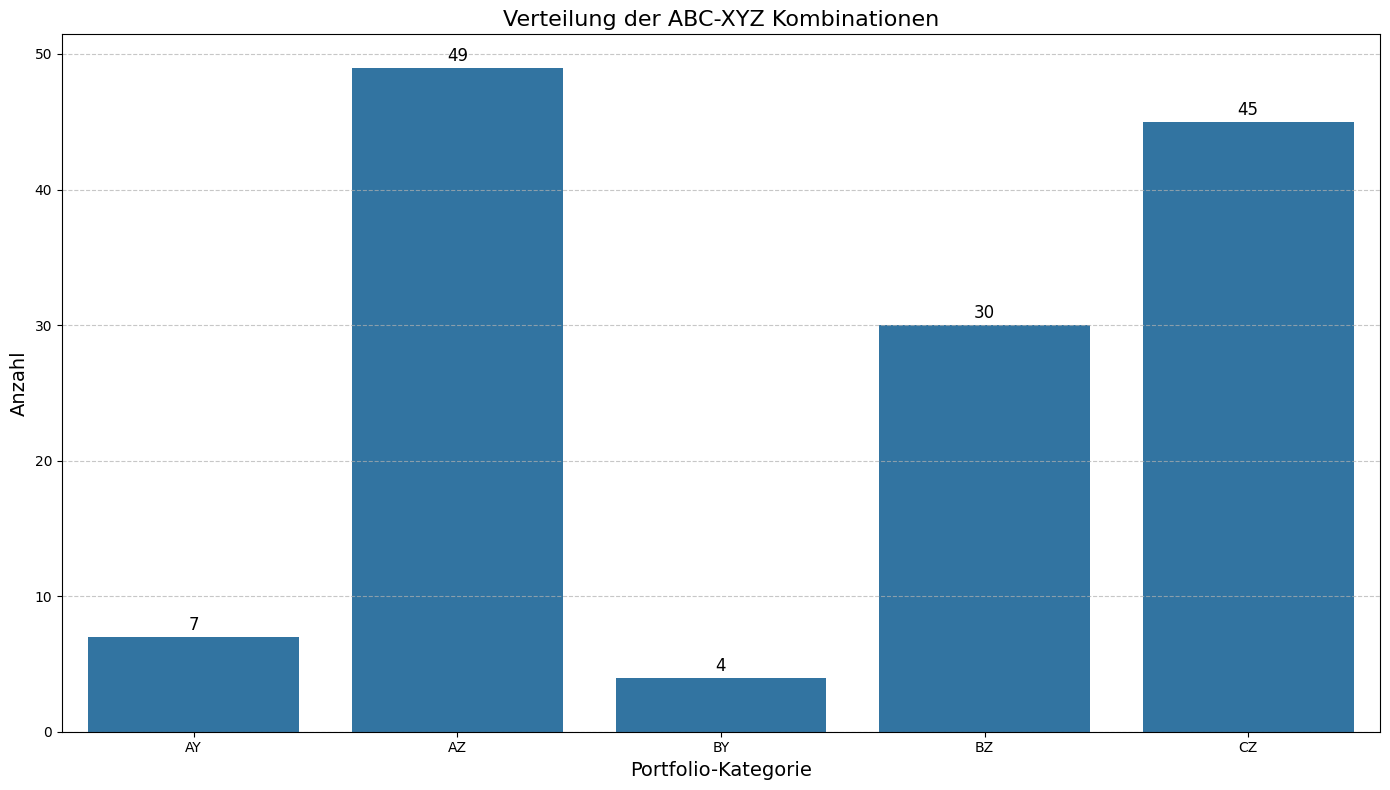

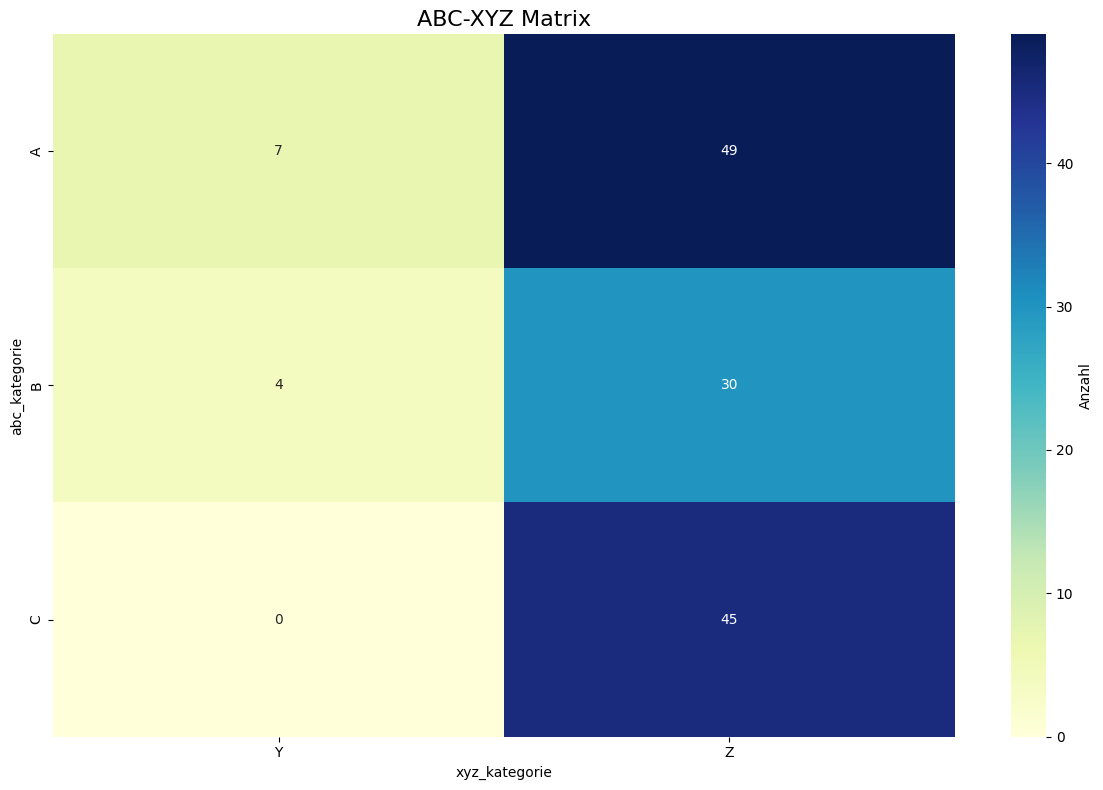

In [36]:
# ABC-XYZ-Kombinationsanalyse erstellen
# Relevante Spalten aus beiden DataFrames zusammenführen
kombiniert_df = pd.merge(
    abc_df[['meal_id', 'meal_name', 'region', 'abc_kategorie', 'revenue', 'percent']], 
    xyz_df[['meal_id', 'region', 'xyz_kategorie', 'variationskoeffizient', 'durchschnitt_pro_woche']],
    on=['meal_id', 'region'],
    how='inner'
)

# Kombinierte Kategorie als neue Spalte erstellen
kombiniert_df['portfolio_kategorie'] = kombiniert_df['abc_kategorie'] + kombiniert_df['xyz_kategorie']

# DataFrame anzeigen
print("ABC-XYZ-Kombinationsanalyse:")
print(kombiniert_df.head(10))

# Zusammenfassung der kombinierten Kategorien
portfolio_summary = kombiniert_df.groupby(['region', 'portfolio_kategorie']).size().unstack(fill_value=0)
print("\nPortfolio-Kategorien Zusammenfassung nach Region:")
print(portfolio_summary)

# Optional: Visualisierung der Verteilung
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

# Zählen wie häufig jede Kombination vorkommt
portfolio_counts = kombiniert_df['portfolio_kategorie'].value_counts().sort_index()

# Balkendiagramm erstellen
ax = sns.barplot(x=portfolio_counts.index, y=portfolio_counts.values)
plt.title('Verteilung der ABC-XYZ Kombinationen', fontsize=16)
plt.xlabel('Portfolio-Kategorie', fontsize=14)
plt.ylabel('Anzahl', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Werte über den Balken anzeigen
for i, v in enumerate(portfolio_counts.values):
    ax.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# Optional: Heatmap für eine intuitive Darstellung
plt.figure(figsize=(12, 8))
heatmap_data = kombiniert_df.groupby(['abc_kategorie', 'xyz_kategorie']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='d', cbar_kws={'label': 'Anzahl'})
plt.title('ABC-XYZ Matrix', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Erstellen eines neuen DataFrames mit den Meals und ihren Portfolio-Kategorien nach Region
meal_portfolio_df = pd.DataFrame()

# Für jede Region ein separates DataFrame erstellen
for region in regions:
    # Filtern der kombinierten Daten für diese Region
    region_portfolio = kombiniert_df[kombiniert_df['region'] == region].copy()
    
    # Spalten umbenennen, um die Region zu kennzeichnen
    region_columns = {
        #'abc_kategorie': f'abc_{region}',
        #'xyz_kategorie': f'xyz_{region}',
        'portfolio_kategorie': f'portfolio_{region}',
        #'revenue': f'revenue_{region}',
        #'percent': f'percent_{region}',
        #'variationskoeffizient': f'variations_koef_{region}',
        #'durchschnitt_pro_woche': f'durchschnitt_{region}'
    }
    
    # Spalten umbenennen
    region_portfolio.rename(columns=region_columns, inplace=True)
    
    # Unwichtige Spalten entfernen
    cols_to_keep = ['meal_id', 'meal_name'] + list(region_columns.values())
    region_portfolio = region_portfolio[cols_to_keep]
    
    # Wenn es das erste DataFrame ist, initialisieren wir meal_portfolio_df
    if meal_portfolio_df.empty:
        meal_portfolio_df = region_portfolio
    else:
        # Ansonsten führen wir die Daten zusammen
        meal_portfolio_df = pd.merge(
            meal_portfolio_df,
            region_portfolio,
            on=['meal_id', 'meal_name'],
            how='outer'
        )

# Jetzt haben wir ein DataFrame mit Portfolio-Kategorien für jede Region
# Fügen wir dies zum meals_df hinzu
meals_with_portfolio = pd.merge(
    meals_df,
    meal_portfolio_df,
    left_on='meal_id',
    right_on='meal_id',
    how='left'
)



meal_portfolio_df.head()

,meal_id,meal_name,abc_Region-Kassel,xyz_Region-Kassel,portfolio_Region-Kassel,abc_Region-Luzern,xyz_Region-Luzern,portfolio_Region-Luzern,abc_Region-Wien,xyz_Region-Wien,portfolio_Region-Wien
0,1062,Beef Goulash,A,Y,AY,A,Y,AY,A,Y,AY
1,1109,Wild Mushroom Risotto,A,Z,AZ,A,Z,AZ,A,Z,AZ
2,1198,Vegetable Stir Fry,B,Y,BY,C,Z,CZ,C,Z,CZ
3,1207,Authentic Carbonara,A,Z,AZ,A,Z,AZ,A,Z,AZ
4,1216,Gourmet Curry Selection,C,Z,CZ,C,Z,CZ,C,Z,CZ


### Pseudocode

In [23]:
predicted_Menge = 0
forecast_Menge = 0
zutaten = []
einkaufskosten = 0
lagerkosten = 0
opportunitätskosten = 0
penalty_cost = 0

In [24]:
differenzmenge = predicted_Menge - forecast_Menge

if differenzmenge > 0:  # Overprediction
    for zutat in zutaten:
        if zutat.is_perishable:
            penalty_cost += einkaufskosten
            penalty_cost += (lagerkosten + opportunitätskosten)
        else:
            penalty_cost += (lagerkosten + opportunitätskosten)

elif differenzmenge < 0:  # Underprediction
    penalty_cost += (einkaufskosten * 1.5)
